# Analyze Crime Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import folium
from folium.plugins import HeatMap

import random
from collections import Counter

# Ensure all columns are displayed
pd.set_option('display.max_columns', None)

In [2]:
dir_path = '/path/to/data/directory/' # Change to your directory path
file_name = 'cleaned_data.csv' # Change to your file name

In [3]:
# read CSV in chunks
def read_in_chunks(file_path, chunk_size=100_000): #Set chunk size
    df_list = []
    chunks = pd.read_csv(file_path, 
                         chunksize=chunk_size, 
                         dtype={'TIME OCC':str,  # Format 24-hour time as '%H%M' str
                               'Premis Cd':str}) # Format Premis Cd values as str
    for chunk in chunks:
        df_list.append(chunk)  # Store chunks in list
    return pd.concat(df_list, ignore_index=True)  # Combine chunks into full DataFrame

In [4]:
# read a random sample
def read_random_sample(file_path, sample_fraction=0.1): # Set sample size
    full_df = read_in_chunks(file_path)  # Read full data in chunks
    sampled_df = full_df.sample(frac=sample_fraction, random_state=42)  # Take random sample but make random sampling return same results every time
    return sampled_df  

In [5]:
# path to full data
file_path = dir_path +  file_name

In [6]:
# Read full data in chunks
full_df = read_in_chunks(file_path)

In [7]:
full_df.shape

(1005104, 22)

In [8]:
# Read random sample
df = read_random_sample(file_path)

In [9]:
df.shape

(100510, 22)

In [10]:
df.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Mocodes,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc,Status,Status Desc,Crm Cd 1,LOCATION,LAT,LON
624116,221410372,2022-05-06,2022-05-03,04:05:00,14,Pacific,1414,1,522,"VEHICLE, STOLEN - OTHER (MOTORIZED SCOOTERS, B...",0344,32,M,H,102.0,SIDEWALK,IC,Invest Cont,522.0,7TH,33.9996,-118.4690
983199,241410620,2024-06-19,2024-06-19,00:49:00,14,Pacific,1494,1,440,THEFT PLAIN - PETTY ($950 & UNDER),1822 0344,33,F,B,212.0,TRANSPORTATION FACILITY (AIRPORT),IC,Invest Cont,440.0,200 WORLD WY,33.9455,-118.4003
430681,222107656,2022-04-04,2022-04-03,01:04:00,21,Topanga,2132,1,331,THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND ...,0385,45,F,W,501.0,SINGLE FAMILY DWELLING,IC,Invest Cont,331.0,7100 FOREST HILLS RD,34.1980,-118.6402
631116,220322533,2022-12-30,2022-12-26,13:30:00,3,Southwest,361,1,510,VEHICLE - STOLEN,X,0,X,X,101.0,STREET,IC,Invest Cont,510.0,4800 TACANA ST,34.0163,-118.3515
14072,200606894,2020-02-24,2020-02-24,03:55:00,6,Hollywood,637,2,623,BATTERY POLICE (SIMPLE),0447 1212 2004 1822,25,F,H,203.0,OTHER BUSINESS,IC,Invest Cont,623.0,5900 HOLLYWOOD BL,34.1030,-118.3225


# Trends in crime over time

### Extract date and time features

In [11]:
# Convert DATE OCC to datetime and drop NaT values
# non-convertible values are turned into NaT 
df["DATE OCC"] = pd.to_datetime(df["DATE OCC"], errors="coerce")

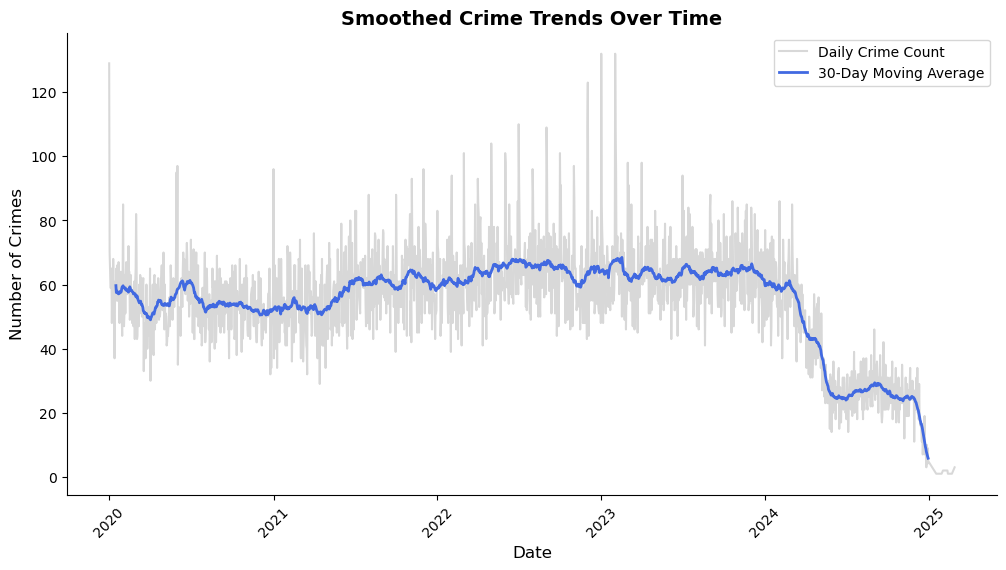

In [12]:
df_clean = df.dropna(subset=["DATE OCC"])

# Aggregate crime counts per day
crime_trends = df_clean.groupby(df_clean["DATE OCC"].dt.date).size()

# Apply a rolling average for smoothing (30-day window)
crime_trends_smooth = crime_trends.rolling(window=30, center=True).mean()

# Plot smoothed crime trends
plt.figure(figsize=(12, 6))
plt.plot(crime_trends.index, 
         crime_trends, 
         alpha=0.3, 
         label="Daily Crime Count", 
         color="gray")

plt.plot(crime_trends.index, 
         crime_trends_smooth, 
         label="30-Day Moving Average", 
         color="royalblue", 
         linewidth=2)

# Titles and labels
plt.title("Smoothed Crime Trends Over Time", fontsize=14, fontweight="bold")
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Crimes", fontsize=12)

# Format x-axis for readability
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Use DateLocator 
# Auto-adjusts date labels
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  

# Remove unnecessary spines for a cleaner look
sns.despine()

plt.legend()
plt.show()

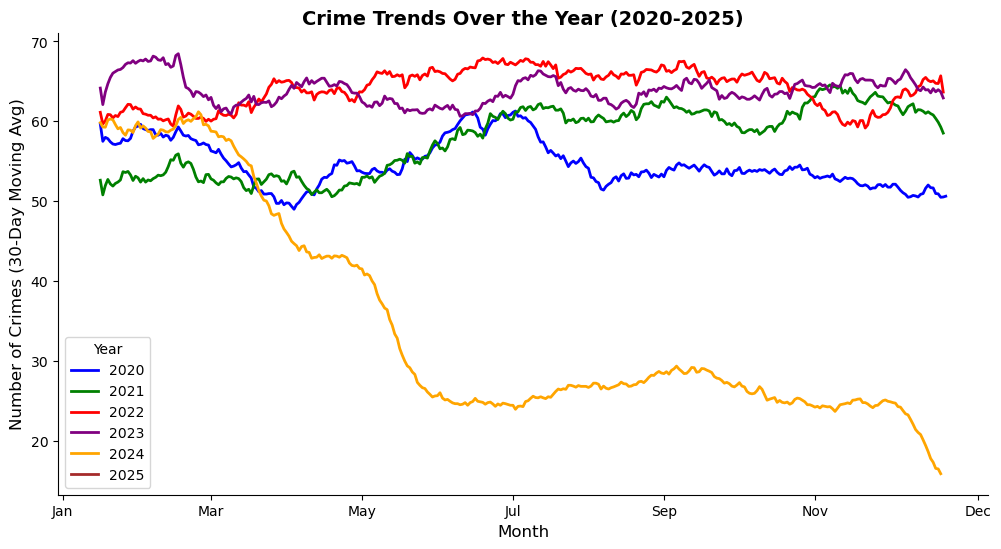

In [13]:
# Convert DATE OCC to datetime and drop NaT values
df["DATE OCC"] = pd.to_datetime(df["DATE OCC"], errors="coerce")
df_clean = df.dropna(subset=["DATE OCC"])

# Filter data for years 2020 to 2025
df_clean = df_clean[(df_clean["DATE OCC"].dt.year >= 2020) & (df_clean["DATE OCC"].dt.year <= 2025)]

# Create figure
plt.figure(figsize=(12, 6))

# Define color palette for each year
colors = ["blue", "green", "red", "purple", "orange", "brown"]

# Loop through each year and plot its trend
for i, year in enumerate(range(2020, 2026)):  
    yearly_data = df_clean[df_clean["DATE OCC"].dt.year == year]  
    crime_trends = yearly_data.groupby(yearly_data["DATE OCC"].dt.day_of_year).size()
    crime_trends_smooth = crime_trends.rolling(window=30, 
                                               center=True).mean()
    
    plt.plot(crime_trends.index, 
             crime_trends_smooth, 
             label=f"{year}", 
             color=colors[i], 
             linewidth=2)

# Titles and labels
plt.title("Crime Trends Over the Year (2020-2025)", fontsize=14, fontweight="bold")
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of Crimes (30-Day Moving Avg)", fontsize=12)

# Set x-axis ticks properly
xtick_positions = [1, 60, 120, 180, 240, 300, 365]
xtick_labels = ["Jan", "Mar", "May", "Jul", "Sep", "Nov", "Dec"]
plt.xticks(ticks=xtick_positions, labels=xtick_labels, fontsize=10)

plt.yticks(fontsize=10)

# Remove unnecessary spines for a cleaner look
sns.despine()

plt.legend(title="Year")
plt.show()


# Geographic Analysis

## Most common crime locations

In [14]:
print("Top 10 Crime Locations:")
print(df["LOCATION"].value_counts().head(10))

Top 10 Crime Locations:
LOCATION
800 N  ALAMEDA                      ST      247
10200    SANTA MONICA                 BL    184
100    THE GROVE                    DR      176
700 S  FIGUEROA                     ST      161
6TH                          ST             160
7TH                          ST             157
6TH                                         154
11800    SANTA MONICA                 BL    153
600 S  ALVARADO                     ST      146
BROADWAY                                    138
Name: count, dtype: int64


In [15]:
print("\nTop 10 Premises where crimes occur:")
print(df["Premis Desc"].value_counts().head(10))


Top 10 Premises where crimes occur:
Premis Desc
STREET                                          26317
SINGLE FAMILY DWELLING                          16140
MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)    12025
PARKING LOT                                      6978
OTHER BUSINESS                                   4773
SIDEWALK                                         4143
VEHICLE, PASSENGER/TRUCK                         2836
GARAGE/CARPORT                                   1883
DRIVEWAY                                         1585
DEPARTMENT STORE                                 1471
Name: count, dtype: int64


# High-crime areas 

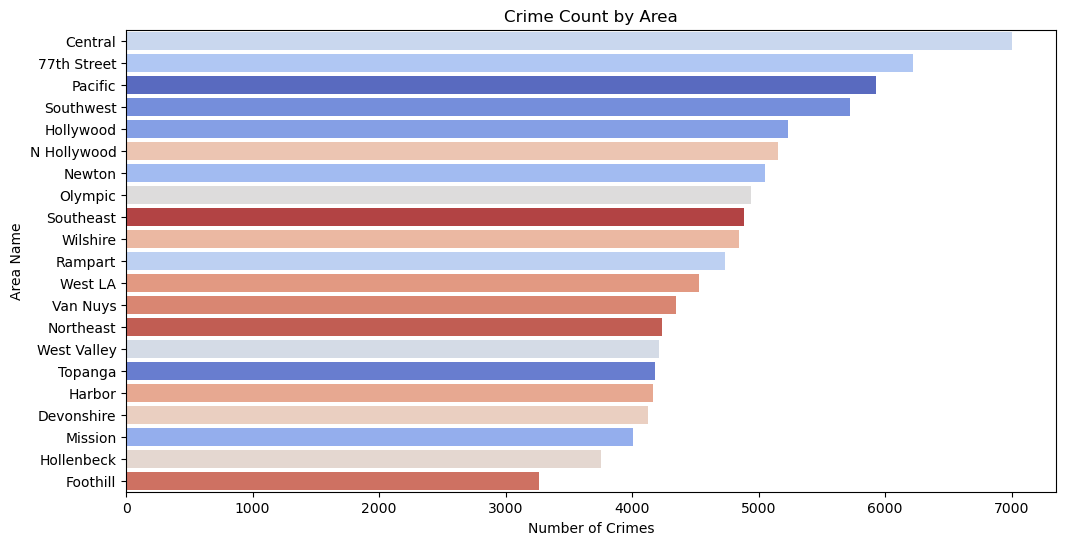

In [16]:
# Identify high-crime areas
plt.figure(figsize=(12, 6))
# sns.countplot(y=df["AREA NAME"], order=df["AREA NAME"].value_counts().index, palette="coolwarm")
sns.countplot(y=df["AREA NAME"], order=df["AREA NAME"].value_counts().index, hue=df["AREA NAME"], palette="coolwarm", legend=False)

plt.title("Crime Count by Area")
plt.xlabel("Number of Crimes")
plt.ylabel("Area Name")
plt.show()

# Crime type analysis

## Most common crimes

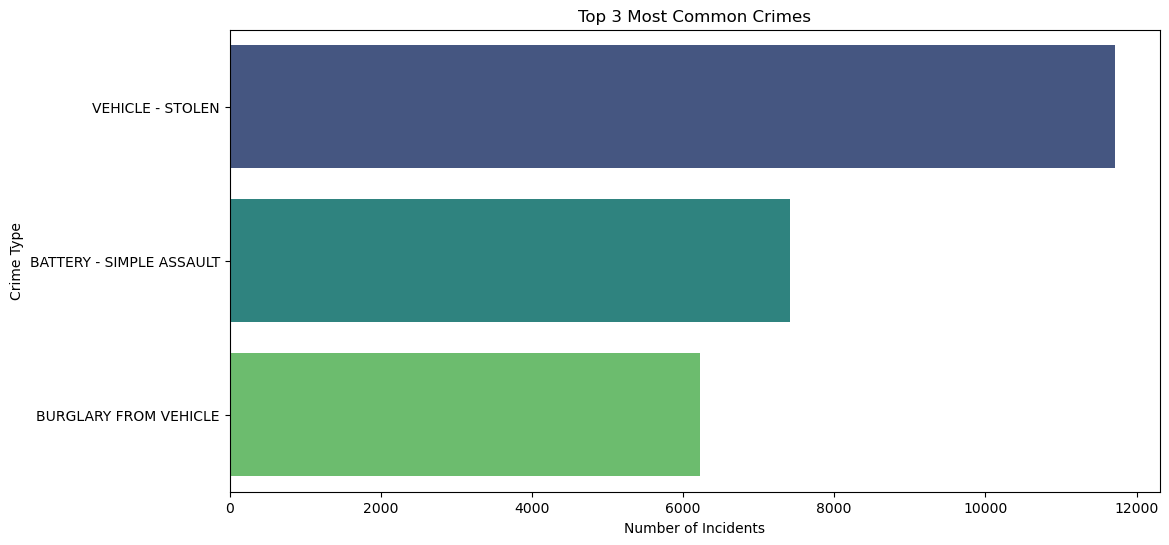

In [17]:
plt.figure(figsize=(12, 6))
top_crimes = df["Crm Cd Desc"].value_counts().head(3)
sns.barplot(y=top_crimes.index, 
            hue=top_crimes.index, 
            x=top_crimes.values, 
            palette="viridis")
# sns.barplot(y=top_crimes.index, x=top_crimes.values)

plt.title("Top 3 Most Common Crimes")
plt.xlabel("Number of Incidents")
plt.ylabel("Crime Type")
plt.show()

## Analyze 'Mocodes' (Modus Operandi)


Top 10 Most Frequent Modus Operandi (MO Codes):
Mocodes
1822    34132
0344    29761
X       15326
0913    15147
0329    13062
Name: count, dtype: int64


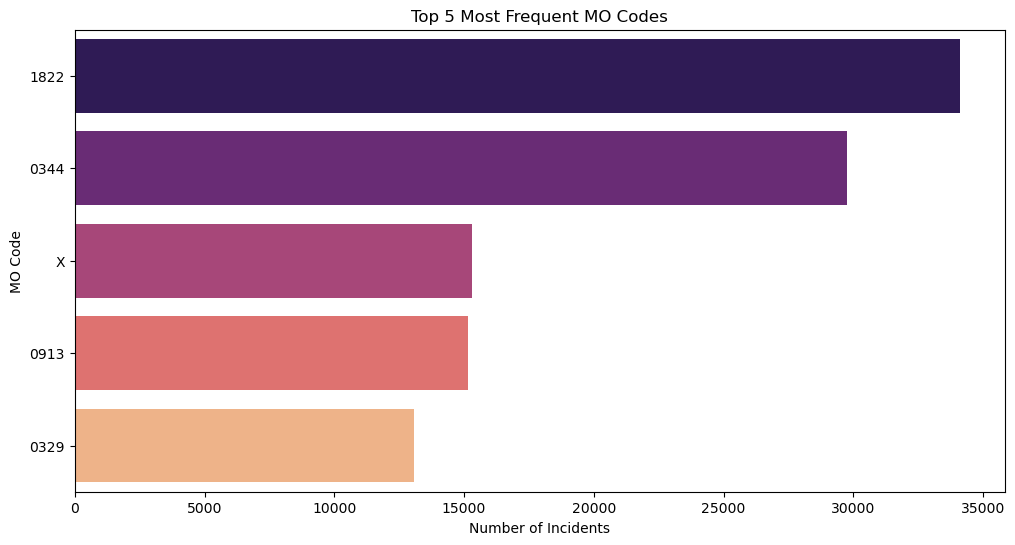

In [18]:
print("\nTop 10 Most Frequent Modus Operandi (MO Codes):")
mo_counts = df["Mocodes"].dropna().str.split().explode().value_counts().head(5)
print(mo_counts)

plt.figure(figsize=(12, 6))

sns.barplot(y=mo_counts.index, 
            hue=mo_counts.index, 
            x=mo_counts.values, 
            palette="magma")
# sns.barplot(y=mo_counts.index, x=mo_counts.values)

plt.title("Top 5 Most Frequent MO Codes")
plt.xlabel("Number of Incidents")
plt.ylabel("MO Code")
plt.show()

## Group by Part 1-2 Classification

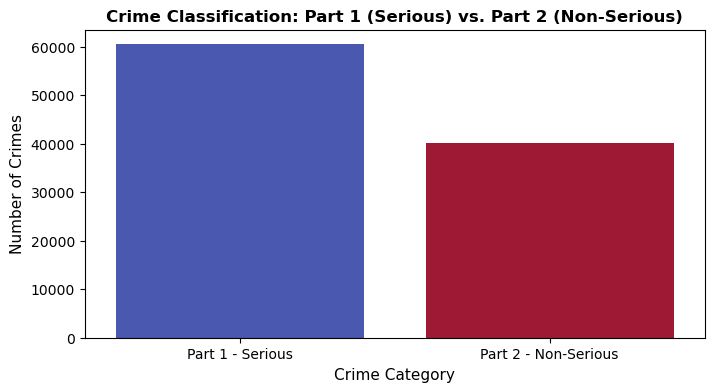

In [19]:
part_classification = df["Part 1-2"].value_counts()

plt.figure(figsize=(8, 4))

# Explicitly setting `hue` and `legend=False` to avoid warnings
sns.barplot(x=part_classification.index, 
            y=part_classification.values,
            hue=part_classification.index,  # Explicitly assign hue
            palette="coolwarm",
            legend=False)  # Hide legend

plt.title("Crime Classification: Part 1 (Serious) vs. Part 2 (Non-Serious)", fontsize=12, fontweight="bold")
plt.xlabel("Crime Category", fontsize=11)
plt.ylabel("Number of Crimes", fontsize=11)

# Custom x-tick labels
plt.xticks([0, 1], ["Part 1 - Serious", "Part 2 - Non-Serious"], fontsize=10)

plt.show()


# Crime Distribution by Age, Gender, and Descent

## Histogram for Vict Age

In [20]:
# Ensure Vict Age is numeric
df["Vict Age"] = pd.to_numeric(df["Vict Age"], errors='coerce')

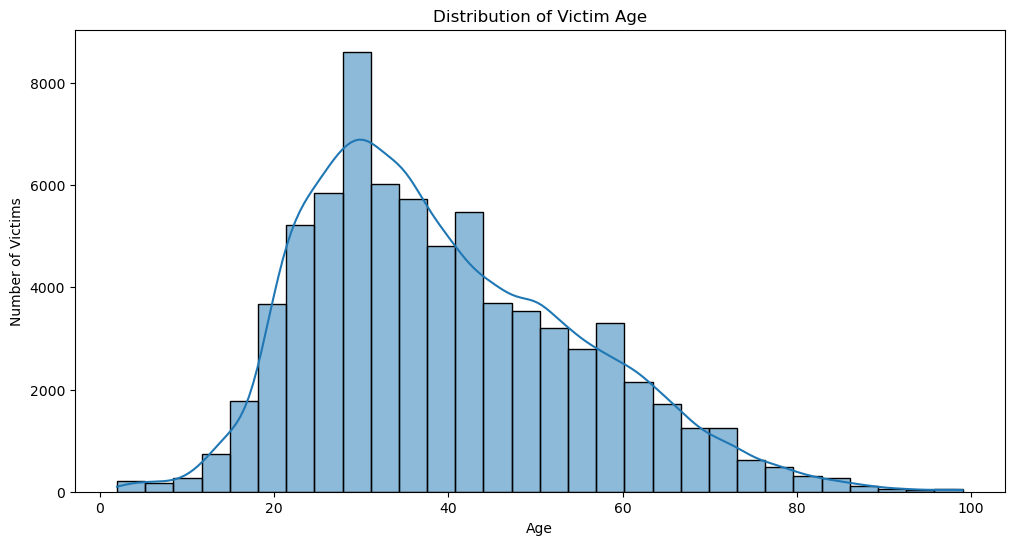

In [21]:
# Crime Distribution by Age
plt.figure(figsize=(12, 6))
# sns.histplot(df["Vict Age"], bins=30, kde=True)
sns.histplot(df[df["Vict Age"] > 0]["Vict Age"], bins=30, kde=True)

plt.title("Distribution of Victim Age")
plt.xlabel("Age")
plt.ylabel("Number of Victims")
plt.show()

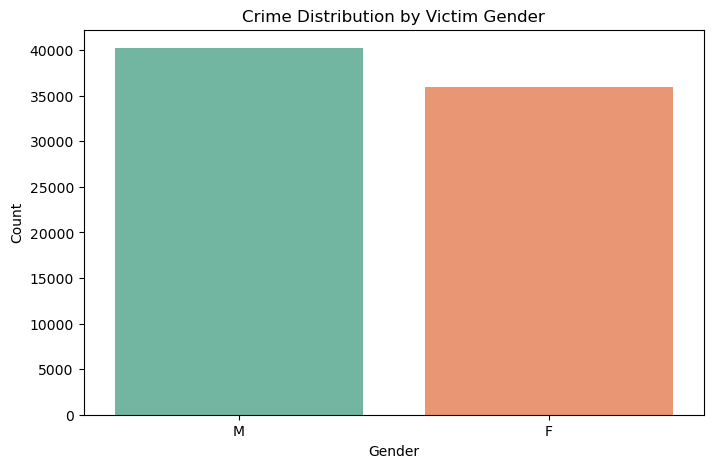

In [23]:
plt.figure(figsize=(8, 5))
sns.countplot(x=df[df["Vict Sex"].isin(["M", "F"])]["Vict Sex"],  
              hue=df[df["Vict Sex"].isin(["M", "F"])]["Vict Sex"],  
              order=["M", "F"],  
              palette="Set2")
plt.title("Crime Distribution by Victim Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()


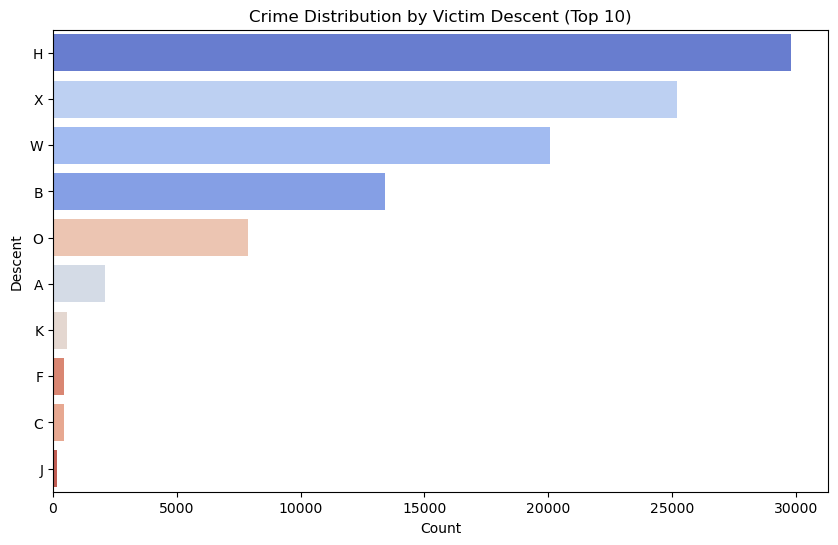

In [25]:
plt.figure(figsize=(10, 6))

# Get the top 10 most common descent categories
top_10_descent = df["Vict Descent"].value_counts().nlargest(10).index

sns.countplot(y=df[df["Vict Descent"].isin(top_10_descent)]["Vict Descent"],  
              hue=df[df["Vict Descent"].isin(top_10_descent)]["Vict Descent"],  
              order=top_10_descent,  
              palette="coolwarm")

plt.title("Crime Distribution by Victim Descent (Top 10)")
plt.xlabel("Count")
plt.ylabel("Descent")
plt.show()

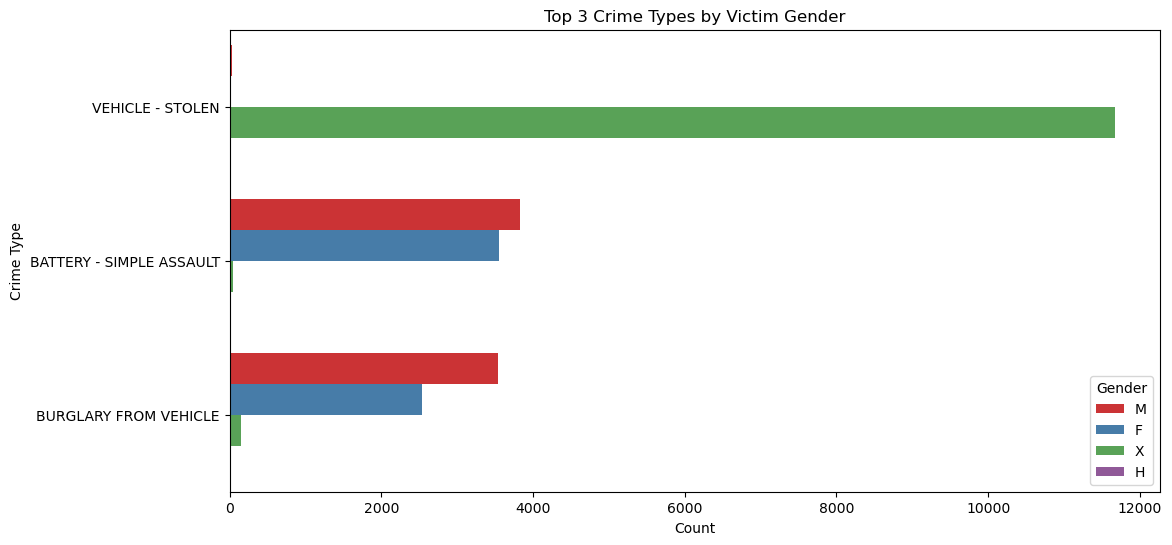

In [26]:
# Crime Type Distribution by Gender
plt.figure(figsize=(12, 6))
sns.countplot(y=df["Crm Cd Desc"], 
              hue=df["Vict Sex"], 
              order=df["Crm Cd Desc"].value_counts().index[:3], 
              palette="Set1")
plt.title("Top 3 Crime Types by Victim Gender")
plt.xlabel("Count")
plt.ylabel("Crime Type")
plt.legend(title="Gender")
plt.show()

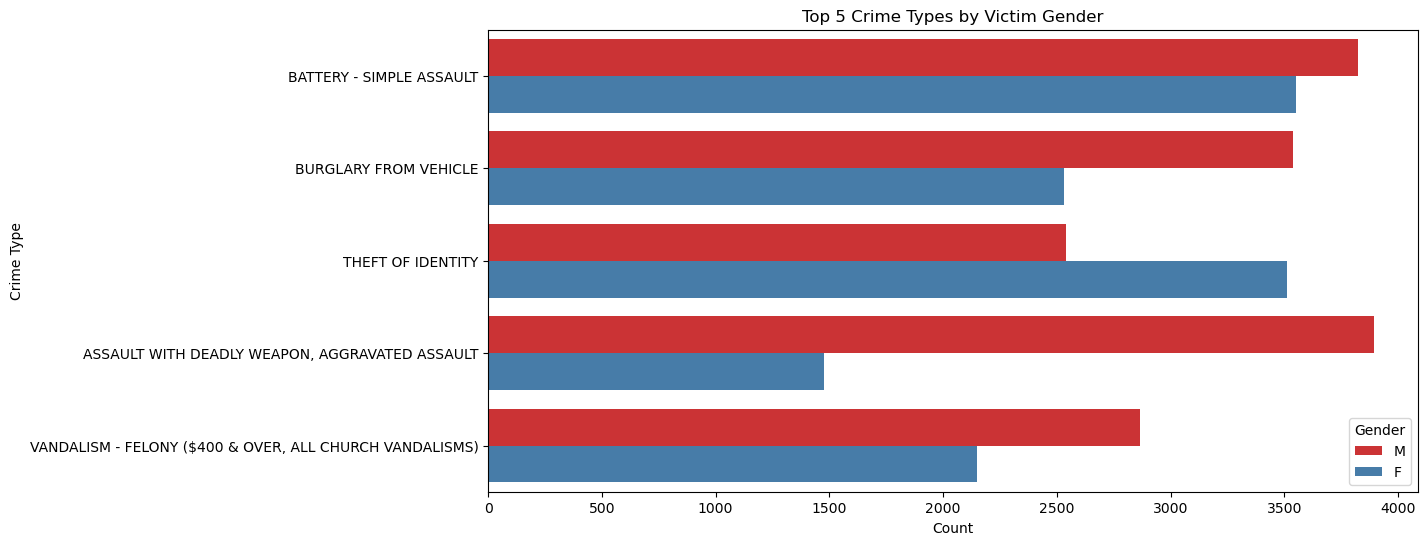

In [27]:
plt.figure(figsize=(12, 6))

# Filter dataset to include only M and F
df_filtered = df[df["Vict Sex"].isin(["M", "F"])]

sns.countplot(y=df_filtered["Crm Cd Desc"],  
              hue=df_filtered["Vict Sex"],  
              order=df_filtered["Crm Cd Desc"].value_counts().index[:5],  
              palette="Set1")

plt.title("Top 5 Crime Types by Victim Gender")
plt.xlabel("Count")
plt.ylabel("Crime Type")
plt.legend(title="Gender")
plt.show()

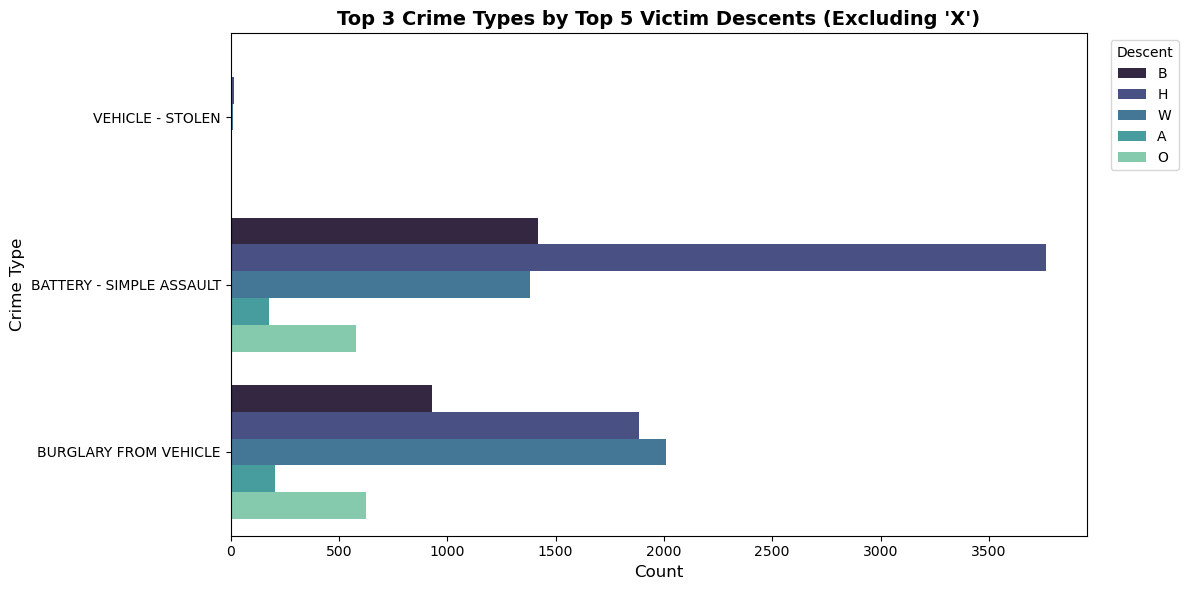

In [28]:
plt.figure(figsize=(12, 6))

# Filter dataset for the top 3 crime types
top_crimes = df["Crm Cd Desc"].value_counts().index[:3]
df_filtered = df[df["Crm Cd Desc"].isin(top_crimes)]

# Exclude "X" from Vict Descent
df_filtered = df_filtered[df_filtered["Vict Descent"] != "X"]

# Get the top 5 most common victim descent categories (excluding "X")
top_descents = df_filtered["Vict Descent"].value_counts().index[:5]
df_filtered = df_filtered[df_filtered["Vict Descent"].isin(top_descents)]

# Plot countplot with filtered descents
sns.countplot(y=df_filtered["Crm Cd Desc"], 
              hue=df_filtered["Vict Descent"], 
              order=top_crimes, 
              palette="mako")

# Title and labels
plt.title("Top 3 Crime Types by Top 5 Victim Descents (Excluding 'X')", fontsize=14, fontweight='bold')
plt.xlabel("Count", fontsize=12)
plt.ylabel("Crime Type", fontsize=12)

# Improve legend placement
plt.legend(title="Descent", bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10, frameon=True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

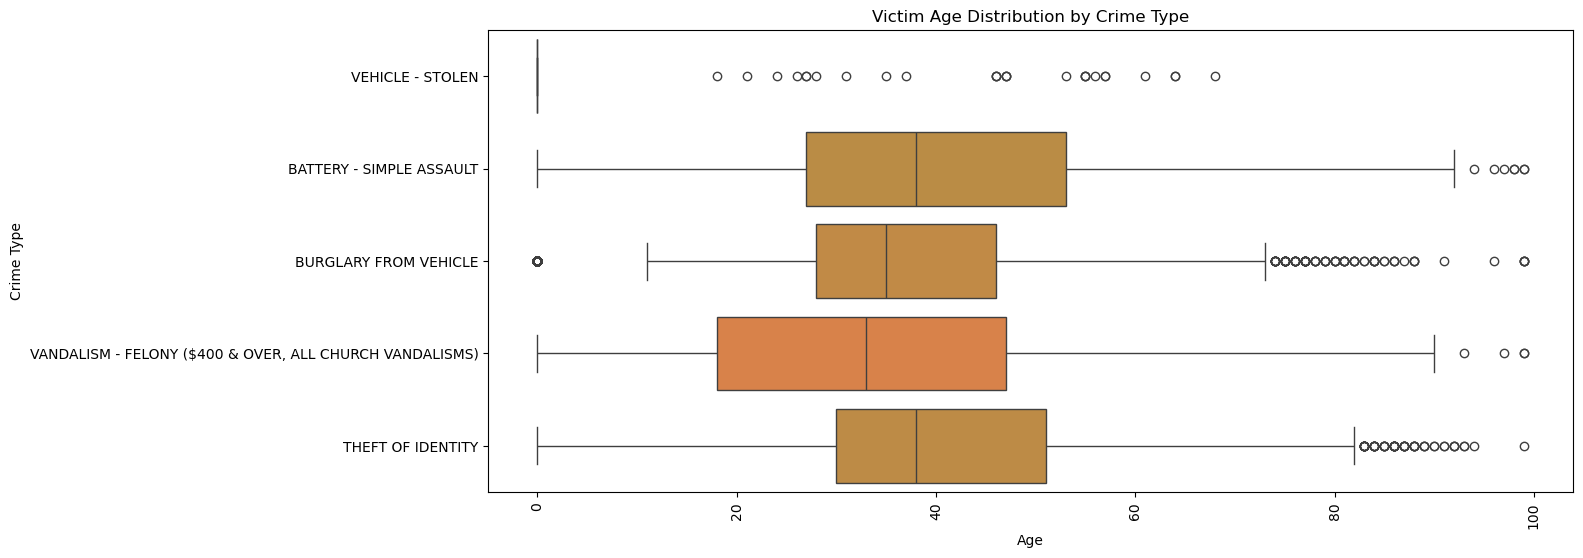

In [30]:
# Age Distribution for Different Crime Types
plt.figure(figsize=(14, 6))
sns.boxplot(x="Vict Age", 
            y="Crm Cd Desc", 
            hue="Crm Cd Desc", 
            data=df, 
            order=df["Crm Cd Desc"].value_counts().index[:5])
plt.xticks(rotation=90)
plt.title("Victim Age Distribution by Crime Type")
plt.xlabel("Age")
# plt.xticks(rotation=45) 
plt.ylabel("Crime Type")
plt.show()

# Analyze Full Data

In [31]:
figs_dir = '/home/ayman/projects/ds_bootcamp/figs/'

In [32]:
def crime_trends_smooth(df):
    # Convert DATE OCC to datetime and drop NaT values
    # non-convertible values are turned into NaT 
    df["DATE OCC"] = pd.to_datetime(df["DATE OCC"], errors="coerce")
    df_clean = df.dropna(subset=["DATE OCC"])

    # Aggregate crime counts per day
    crime_trends = df_clean.groupby(df_clean["DATE OCC"].dt.date).size()
    
    # Apply a rolling average for smoothing (30-day window)
    crime_trends_smooth = crime_trends.rolling(window=30, center=True).mean()
    
    # Plot smoothed crime trends
    plt.figure(figsize=(12, 6))
    plt.plot(crime_trends.index, 
             crime_trends, 
             alpha=0.3, 
             label="Daily Crime Count", 
             color="gray")
    
    plt.plot(crime_trends.index, 
             crime_trends_smooth, 
             label="30-Day Moving Average", 
             color="royalblue", 
             linewidth=2)
    
    # Titles and labels
    plt.title("Smoothed Crime Trends Over Time", fontsize=14, fontweight="bold")
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Number of Crimes", fontsize=12)
    
    # Format x-axis for readability
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    
    # Use DateLocator 
    # Auto-adjusts date labels
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  
    
    # Remove unnecessary spines for a cleaner look
    sns.despine()
    
    plt.legend()
    plt.savefig(f"{figs_dir}smooth_crime_trends.png", 
                dpi=300, 
                bbox_inches="tight")  
    plt.show()

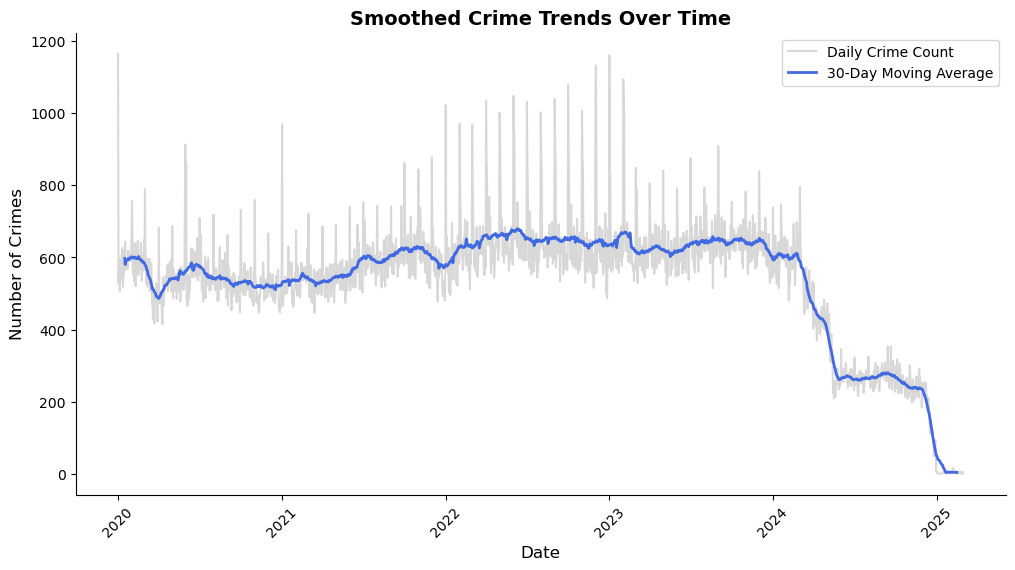

In [33]:
crime_trends_smooth(full_df)

In [34]:
def crimes_over_year(df, syear=2020, fyear=2025):
    # Convert DATE OCC to datetime and drop NaT values
    df["DATE OCC"] = pd.to_datetime(df["DATE OCC"], errors="coerce")
    df_clean = df.dropna(subset=["DATE OCC"])
    
    # Filter data for years 2020 to 2025
    df_clean = df_clean[(df_clean["DATE OCC"].dt.year >= syear) & (df_clean["DATE OCC"].dt.year <= fyear)]
    
    # Create figure
    plt.figure(figsize=(12, 6))
    
    # Define color palette for each year
    colors = ["blue", "green", "red", "purple", "orange", "brown"]
    
    # Loop through each year and plot its trend
    for i, year in enumerate(range(syear, fyear+1)):  
        yearly_data = df_clean[df_clean["DATE OCC"].dt.year == year]  
        crime_trends = yearly_data.groupby(yearly_data["DATE OCC"].dt.day_of_year).size()
        crime_trends_smooth = crime_trends.rolling(window=30, 
                                                   center=True).mean()
        
        plt.plot(crime_trends.index, 
                 crime_trends_smooth, 
                 label=f"{year}", 
                 color=colors[i], 
                 linewidth=2)
    
    # Titles and labels
    plt.title(f"Crime Trends Over the Year ({syear}-{fyear})", 
              fontsize=14, 
              fontweight="bold")
    
    plt.xlabel("Month", fontsize=12)
    plt.ylabel("Number of Crimes (30-Day Moving Avg)", 
               fontsize=12)
    
    # Set x-axis ticks properly
    xtick_positions = [1, 60, 120, 180, 240, 300, 365]
    xtick_labels = ["Jan", "Mar", "May", "Jul", "Sep", "Nov", "Dec"]
    plt.xticks(ticks=xtick_positions, 
               labels=xtick_labels, 
               fontsize=10)
    
    plt.yticks(fontsize=10)
    
    # Remove unnecessary spines for a cleaner look
    sns.despine()
    
    plt.legend(title="Year")
    plt.savefig(f"{figs_dir}crimes_over_year_{syear}_{fyear}.png", 
                dpi=300, 
                bbox_inches="tight")  
    plt.show()


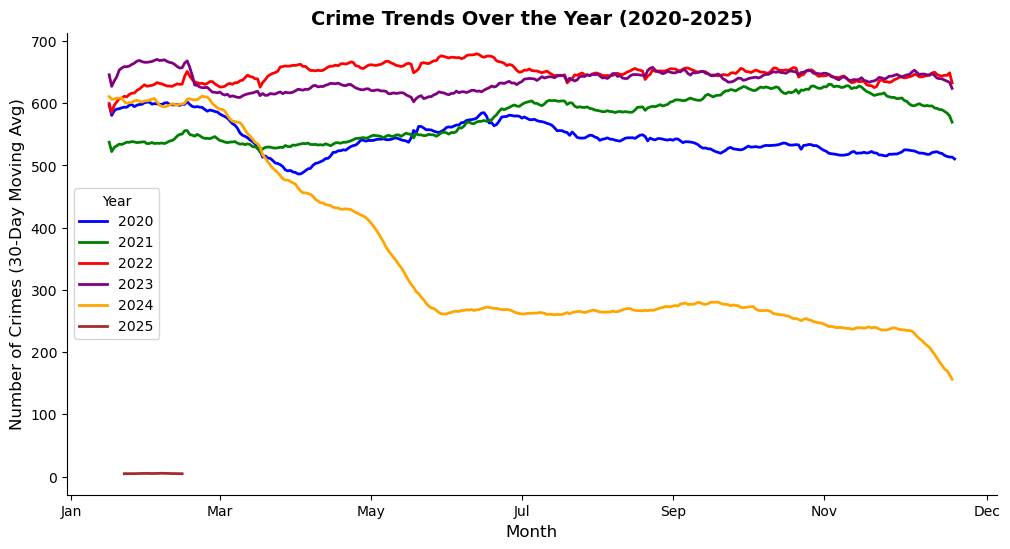

In [35]:
crimes_over_year(full_df)